In [2]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    1: load_data("../stats/fpm_4_2D_x1.json"),
    2: load_data("../stats/fpm_4_2D_x2.json"),
    3: load_data("../stats/fpm_4_2D_x3.json"),
    4: load_data("../stats/fpm_4_2D_x4.json"),
    5: load_data("../stats/fpm_4_2D_x5.json"),
    6: load_data("../stats/fpm_4_2D_x6.json"),
}

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange  # type: ignore


In [3]:
shape = [3, 2]
figsize = (12, 6)

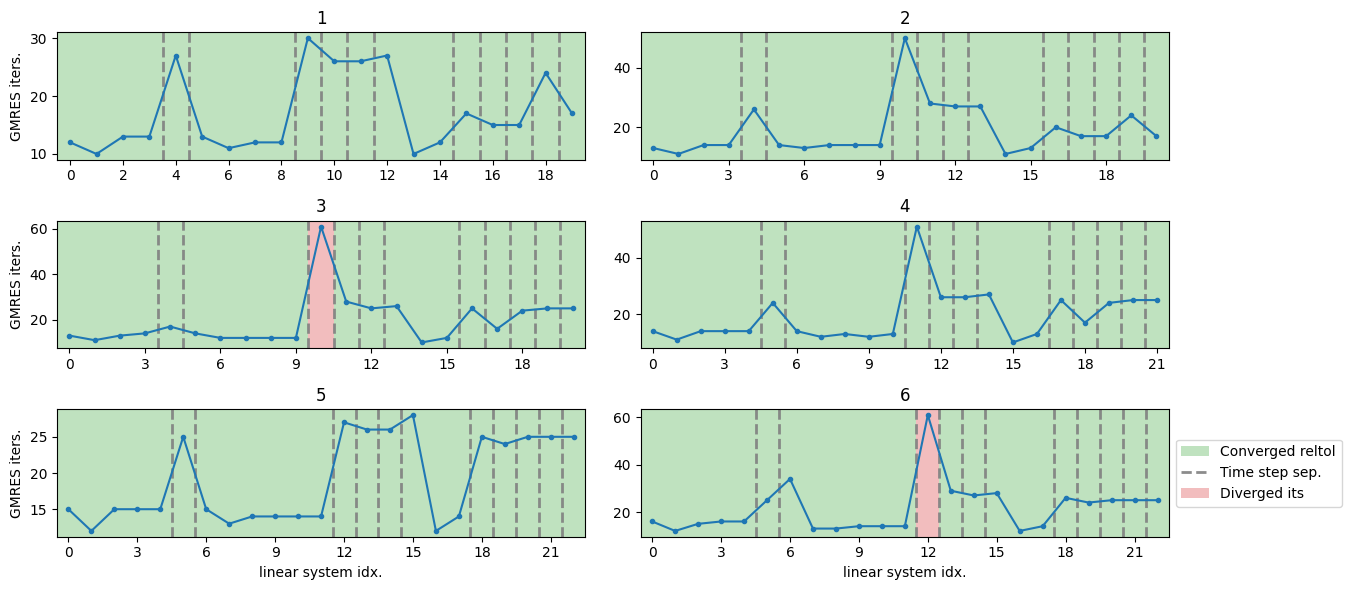

In [4]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker=".")


plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

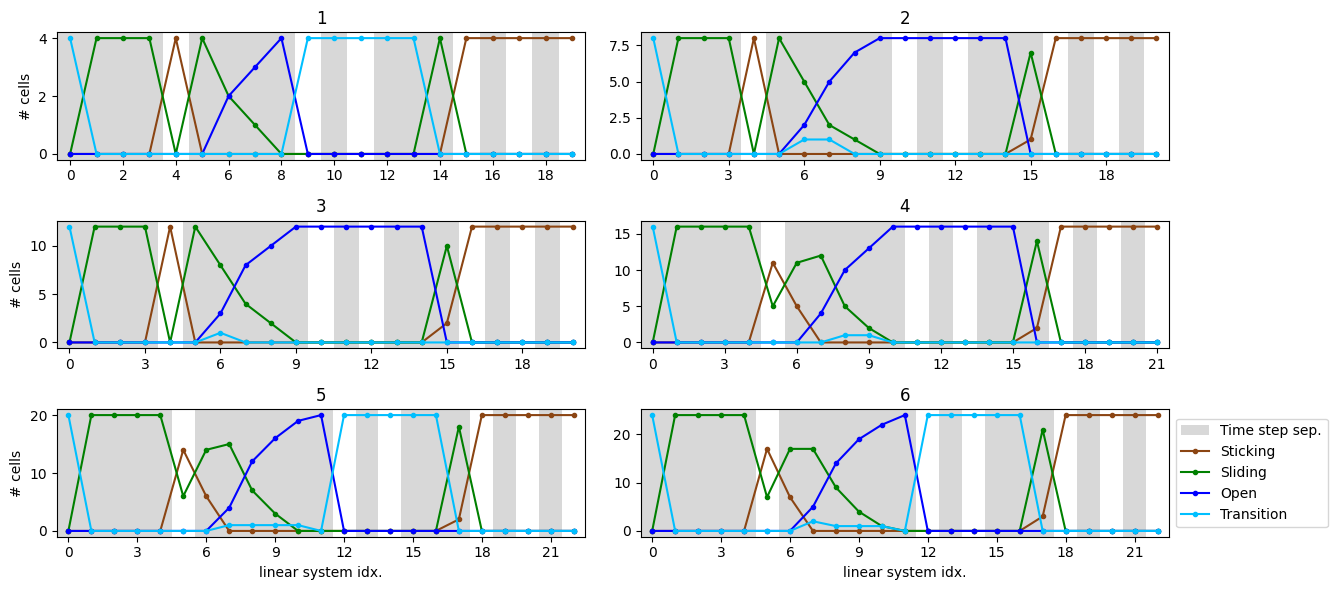

In [5]:
def render_element(entry: Sequence[TimeStepStats]):
    st, sl, op, tr = get_num_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=True, grid=False, legend=True)
    plt.plot(st, label="Sticking", marker=".", color=COLOR_STICKING)
    plt.plot(sl, label="Sliding", marker=".", color=COLOR_SLIDING)
    plt.plot(op, label="Open", marker=".", color=COLOR_OPEN)
    plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)


plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel="# cells")

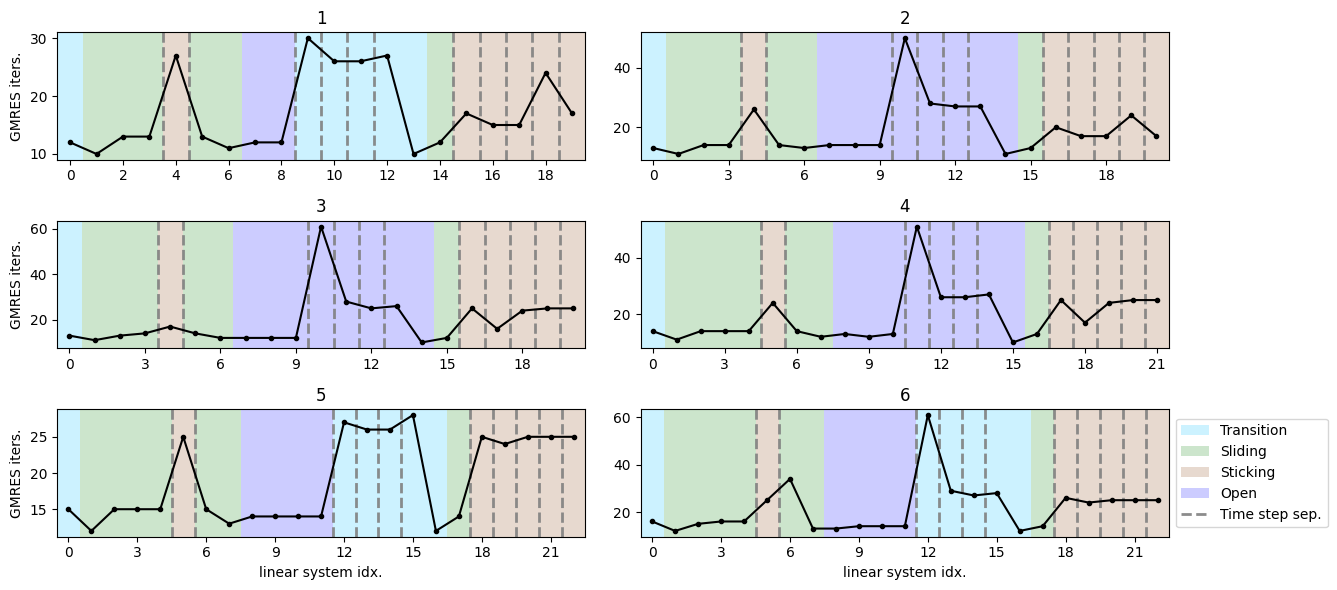

In [6]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker=".", color="black")
    # plt.ylim(top=15)


plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

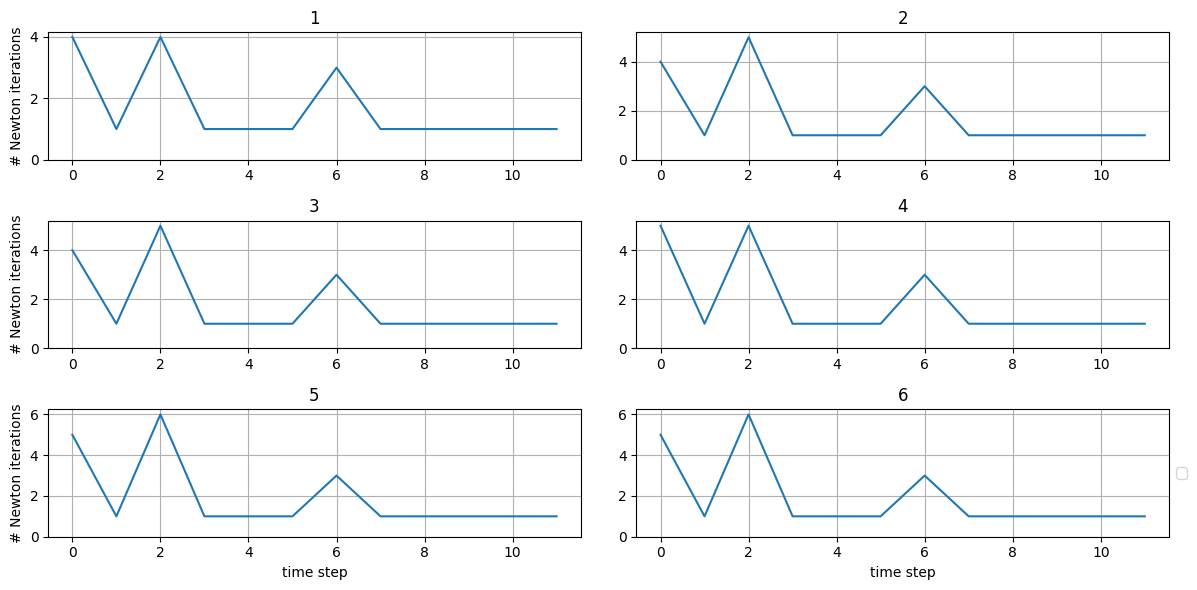

In [7]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()


plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    ylabel="# Newton iterations",
    xlabel="time step",
)

Text(0.5, 0, 'Simulation time, s')

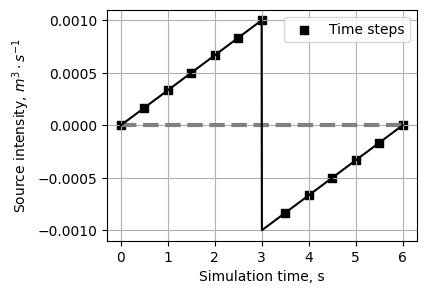

In [8]:
from fpm_4_2D import make_model

model = make_model(cell_size_multiplier=1)
model.prepare_simulation()
source = []
t_list = np.linspace(0, 6, 13, endpoint=True)
for t in t_list:
    source.append(model.get_source_intensity(t))

source_fine = []
t_list_fine = np.linspace(0, 6, 1000, endpoint=True)
for t in t_list_fine:
    source_fine.append(model.get_source_intensity(t))

plt.figure(figsize=(4, 3))
plt.plot([0, 6], [0, 0], color='grey', linestyle='--', linewidth=3)
plt.plot(t_list_fine, source_fine, color="black")
plt.scatter(t_list, source, marker="s", label="Time steps", color="black")
plt.grid()
plt.legend()    
plt.ylabel(r"Source intensity, $m^3 \cdot s^{-1}$")
plt.xlabel("Simulation time, s")

# Testing bad matrix

In [9]:
assert False

AssertionError: 

In [12]:
from fpm_4_2D import make_model
cell_size_multiplier=3
model = make_model(cell_size_multiplier=cell_size_multiplier)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()



num sticking: 0
num sliding: 0
num open: 0
num transition: 12


In [13]:
mat_idx = 10
entry = data[cell_size_multiplier]
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

61


In [14]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)  # 1

model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

0
0
12
0


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Solve  took: 0.17
True residual permuted: 2.844027687594216e-07
True residual: 2.839626269054823e-07
PETSc Converged Reason: -3
lambda min: 0.3901149300992821


{'mat_Q': BlockMatrixStorage of shape (6534, 6534) with 245264 elements with 6x6 active groups,
 'rhs_Q': array([-6.77626358e-21, -1.69406589e-20, -3.38813179e-21, ...,
         1.65482094e-12,  2.67323158e-12,  2.31657427e-12])}

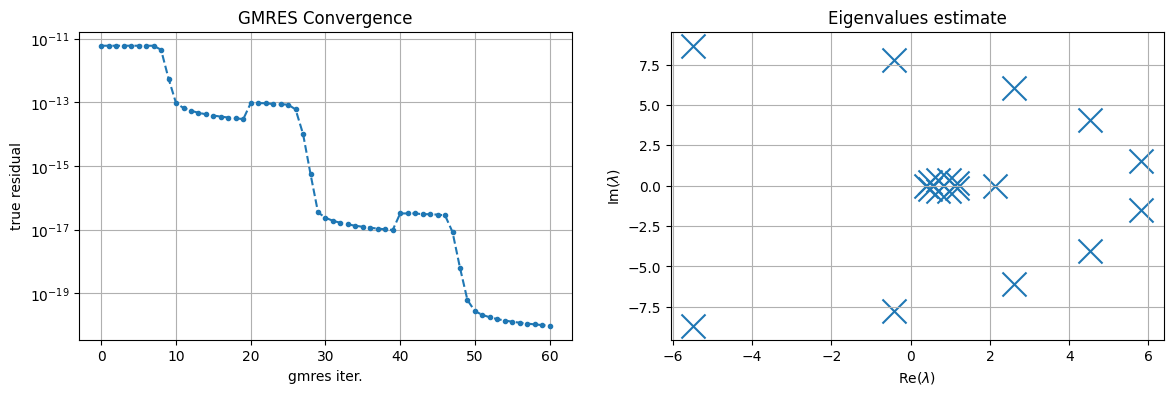

In [15]:
sol = None
schema = model._prepare_solver()
solve_petsc_new(
    model.bmat,
    schema,
    rhs_global=rhs,
    # Qleft=model.Qleft,
    Qright=model.Qright,
    pc_side="right",
    tol=1e-10,
)

In [16]:
J = model.bmat

Solve  took: 0.02
True residual permuted: 1.3259097964727889e-11
True residual: 0.9999622352532563
PETSc Converged Reason: 2


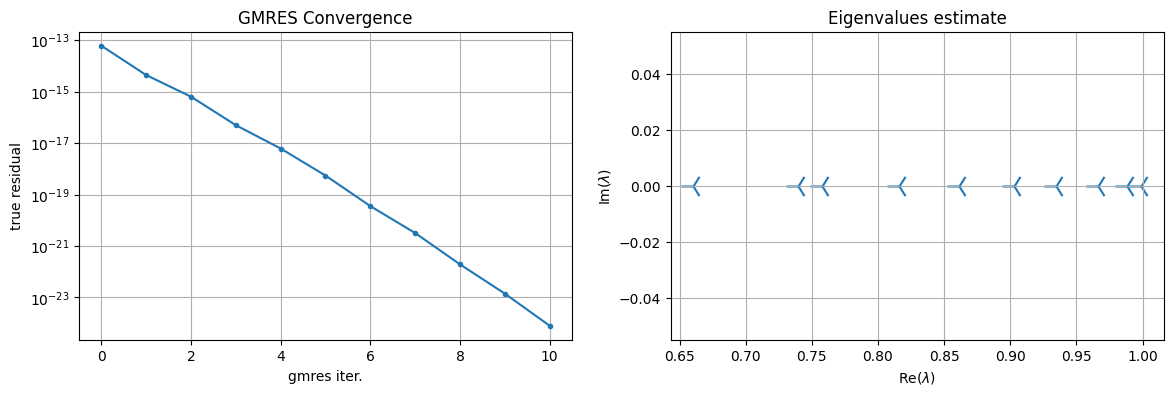

In [60]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import *

factorization_type = "upper"

schema = SolveSchema(
    # groups=[4],
    # solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    # factorization_type=factorization_type,
    # complement=SolveSchema(
    # groups=[3],
    # solve=lambda bmat: PetscILU(bmat[[3]].mat),
    # invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
    # factorization_type=factorization_type,
    # complement=SolveSchema(
    groups=[
        1,
    ],
    solve=lambda bmat: PetscAMGMechanics(
        mat=bmat[[1]].mat,
        dim=model.nd,
        null_space=model.build_mechanics_near_null_space(groups=[1]),
    ),
    # solve='direct',
    # invertor='direct',
    # invertor_type="physical",
    # invertor=lambda bmat: make_fs_experimental(model, J)[[0, ]].mat,
    # factorization_type=factorization_type,
    # # only_complement=True,
    # complement=SolveSchema(
    #     groups=[0, ],
    #     # solve='direct',
    #     solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, ]].mat),
    # ),
    # ),
    # ),
    # ),
)

res = solve_petsc_new(
    model.bmat,
    schema,
    # Qleft=model._Qleft,
    Qright=model._Qright,
    rhs_global=rhs,
    pc_side="right",
    tol=1e-10,
    logx_eigs=False,
)

In [38]:
J00 = J[0,0].mat
J01 = J[0,1].mat
J10 = J[1,0].mat
J11 = J[1,1].mat

D = J[[1,0]].empty_container()
D[1,1] = inv(J11)
# D[0,0] = inv(J00 - J01 @ D[1,1].mat @ J10)
D[0,0] = inv(J00 + make_fs_experimental(model, J)[[0]].mat)

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [39]:
U = D.empty_container()
U[0,0] = csr_ones(J00.shape[0])
U[1,1] = csr_ones(J11.shape[0])
U[1,0] = -D[1,1].mat @ J10 

In [40]:
tmp = D.empty_container()
tmp.mat =  scipy.sparse.csr_matrix(J[[1,0]].mat.A @ U.mat.A @ D.mat.A)

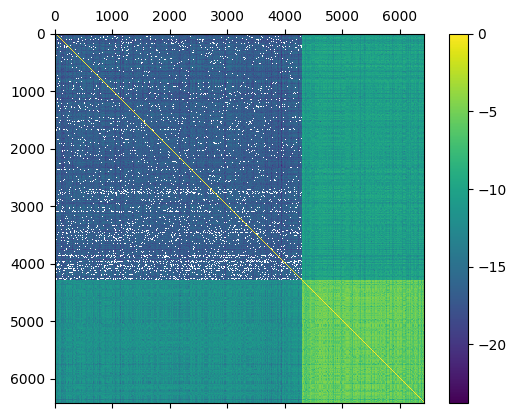

In [43]:
tmp.matshow()

Solve  took: 0.16
True residual decrease: 3.821798696318517e-06
PETSc Converged Reason: 2


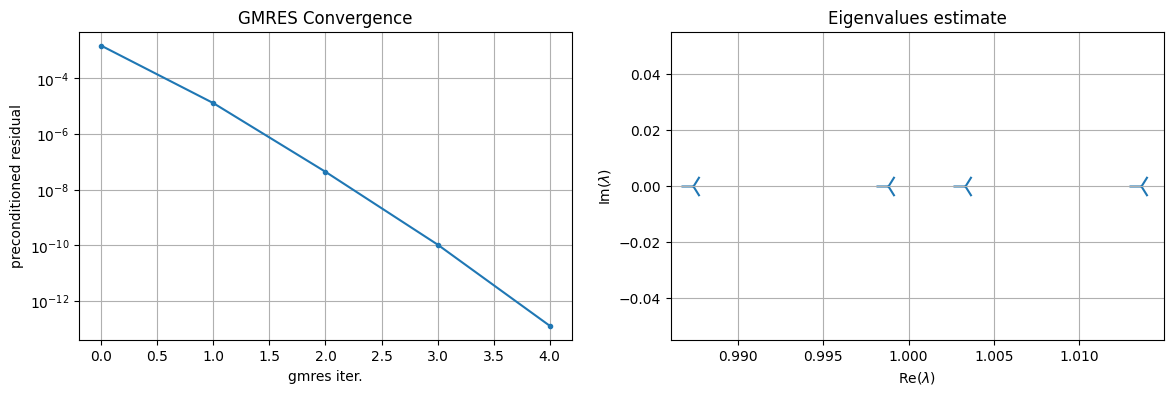

In [48]:
solve_petsc(J[[1,0]].mat, prec=scipy.sparse.csr_matrix(U.mat.A @ D.mat.A), rhs=J[[1,0]].local_rhs(rhs))

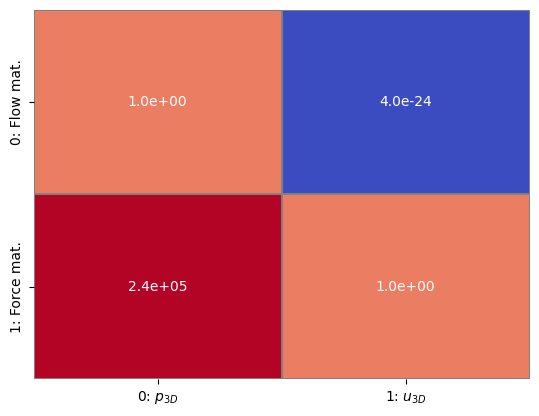

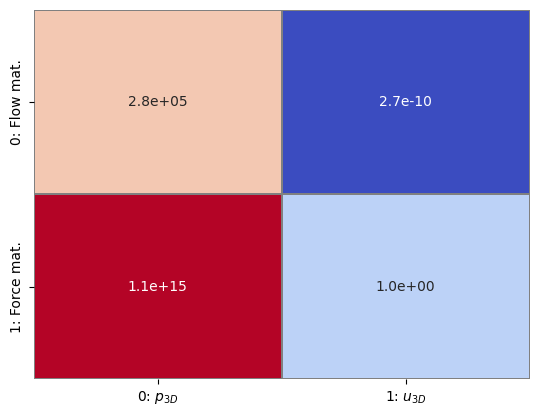

In [ ]:
tmp.plot_max()

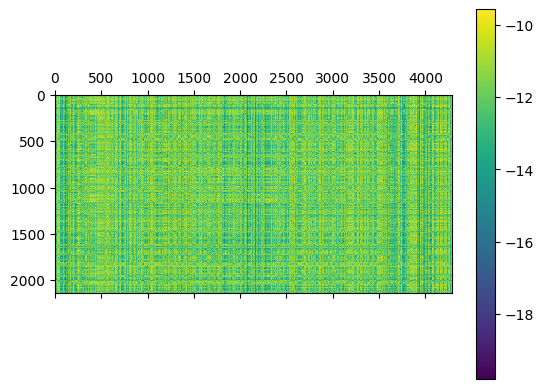

In [ ]:
tmp[0,1].matshow(log=True)

In [ ]:
matrix_cell_centers = model.mdg.subdomains(dim=model.nd)[0].cell_centers
cell_centers = [matrix_cell_centers] + [
    intf.cell_centers for intf in model.mdg.interfaces(dim=model.nd - 1)
]
cell_centers = np.concatenate(cell_centers, axis=1)

x, y, z = cell_centers
num_dofs = cell_centers.shape[1]

null_space = []
vec = np.zeros((2, num_dofs))
vec[0] = 1
null_space.append(vec.ravel("f"))
vec = np.zeros((2, num_dofs))
vec[1] = 1
null_space.append(vec.ravel("f"))
vec = np.zeros((2, num_dofs))
vec[0] = -x
vec[1] = y
null_space.append(vec.ravel("f"))


null_space = np.array(null_space)
null_space

array([[ 1.        ,  0.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [-0.27481167,  0.49977076, -0.06358057, ...,  0.5       ,
        -0.68333333,  0.5       ]])

Returning only Schur complement based on [1, 5]
Solve  took: 0.02
True residual permuted: 2.6210828252676767e-11
True residual: 0.9999407902249942
PETSc Converged Reason: 2


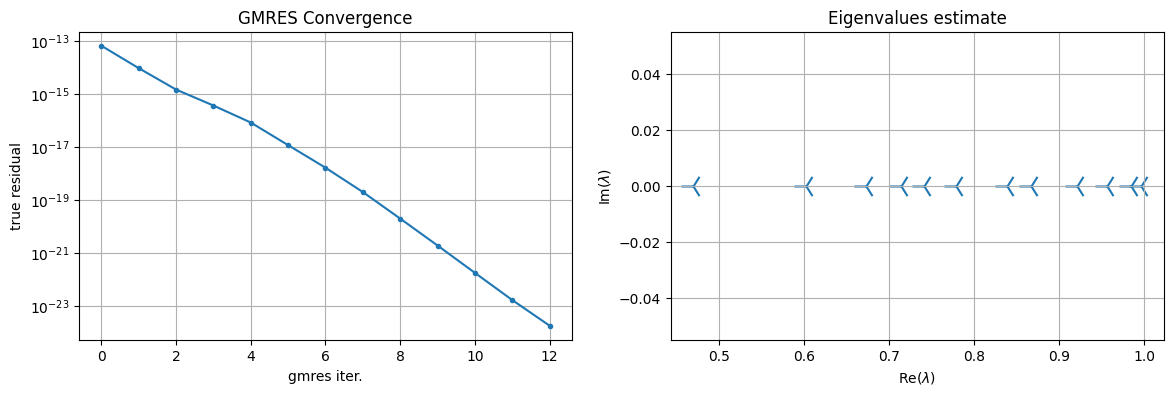

In [ ]:
schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    only_complement=True,
    complement=SolveSchema(
        groups=[1, 5],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd, null_space=None),
    ),
)

res = solve_petsc_new(
    model.bmat,
    schema,
    Qleft=model._Qleft,
    Qright=model._Qright,
    rhs_global=rhs,
    pc_side="right",
    tol=1e-10,
    logx_eigs=False,
)